# The analysis for journey data

## An analysis for the cycle hire data

We will consider the influence of multiple factors of the physical environment on the number of travels

In [1]:
# load libraries

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

import scipy.stats
import matplotlib.pyplot as plt


In [2]:
# set path
points_path = os.path.join('data', 'cycles', 'points')
points_fn = 'BikePoints.geojson'
journeys_path = os.path.join('data', 'cycles', 'journeys')
journeys_gdf_fn = 'journeys_gdf.geoparquet'
elevation_path = os.path.join('data', 'elevation', 'london_elevation.tif')
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

In [3]:
# load data

journeys_gdf = gpd.read_parquet(os.path.join(journeys_path, journeys_gdf_fn))

## Basic analysis of the data

First, looking at the characteristics of the dataset.

In [4]:
# clean data

# convert dates into datetime format
dates = ['Start date', 'End date']
for d in dates:
    journeys_gdf[d] = pd.to_datetime(journeys_gdf[d], format = '%Y-%m-%d %H:%M')

# convert bike model into categories
journeys_gdf['Bike model'] = journeys_gdf['Bike model'].astype('category')

# remove total duration
journeys_gdf = journeys_gdf.drop('Total duration', axis = 1)

journeys_gdf.dtypes

Number                          int64
Start date             datetime64[ns]
Start station                  object
End date               datetime64[ns]
End station                    object
Bike number                     int64
Bike model                   category
Total duration (ms)             int64
start_id                       object
start_name                     object
start_ports                    object
start_location                 object
start_zone                     object
start_height                  float32
start_LSOA11CD                 object
start_LSOA11NM                 object
start_cc_zone                    bool
end_id                         object
end_name                       object
end_ports                      object
end_location                   object
end_zone                       object
end_height                    float32
end_LSOA11CD                   object
end_LSOA11NM                   object
end_cc_zone                      bool
geometry    

In [5]:
# filter by start date
journeys_gdf = journeys_gdf[journeys_gdf['Start date'] >= '2022-12-01'].copy()

In [13]:
journeys_gdf.height_diff.describe()

count    8.414631e+06
mean    -2.199563e-01
std      9.165493e+00
min     -4.387600e+01
25%     -4.115751e+00
50%      0.000000e+00
75%      3.755500e+00
max      4.387600e+01
Name: height_diff, dtype: float64

<Axes: xlabel='Start date,Start date'>

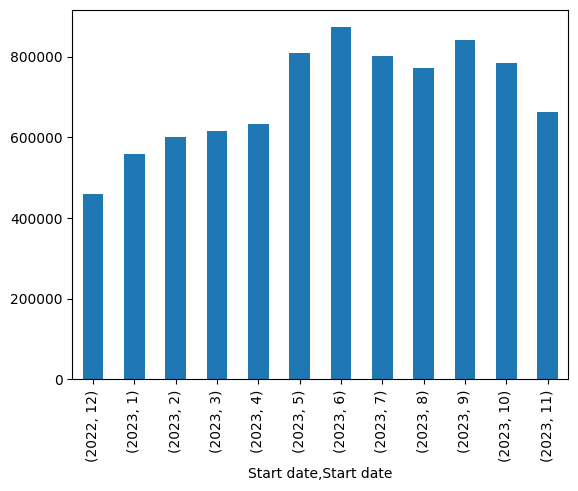

In [22]:
# draw bar chart by month
journeys_gdf.groupby([journeys_gdf['Start date'].dt.year, journeys_gdf['Start date'].dt.month]).Number.count().plot(kind = 'bar')

In [6]:
# calculate mean of height distance
journeys_gdf.height_diff.mean()

-0.21995632

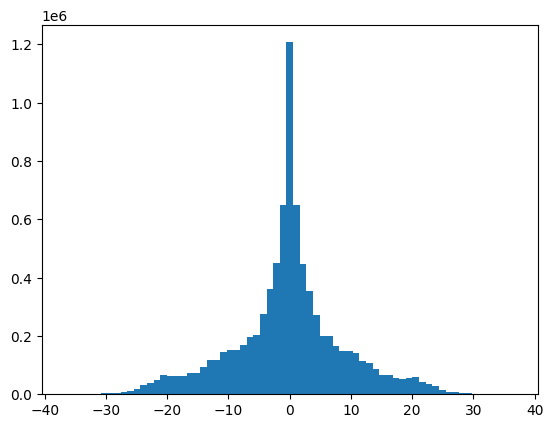

In [29]:
# draw histogram of height distance

# set up plot
fig, ax = plt.subplots(1, 1)

# add histogram
ax.hist(
    journeys_gdf.height_diff,
    bins = 81
)

# set limits
ax.set_xlim(-40.5, 40.5)

plt.show()


In [7]:
journeys_gdf[journeys_gdf['Start station'] != journeys_gdf['End station']].height_diff.mean()

-0.22877766

In [8]:
scipy.stats.ttest_1samp(journeys_gdf.height_diff, popmean = 0)

TtestResult(statistic=-69.61426590290411, pvalue=0.0, df=8414630)

### The average height difference

The average of the height difference is -0.22 m. From the one sample T-test, the null hypothesis of average being 0 is rejected, and is statistically significant, concluding that on average the shared cycles are used more downhill than uphill.

(array([1.443276e+06, 2.202603e+06, 1.763172e+06, 1.216677e+06,
        7.556930e+05, 4.513590e+05, 2.545110e+05, 1.445900e+05,
        8.518200e+04, 4.782000e+04, 2.491700e+04, 1.258100e+04,
        6.461000e+03, 2.777000e+03, 1.500000e+03, 9.490000e+02,
        3.900000e+02, 1.320000e+02, 3.600000e+01, 5.000000e+00]),
 array([    0.        ,   858.53878817,  1717.07757635,  2575.61636452,
         3434.15515269,  4292.69394087,  5151.23272904,  6009.77151721,
         6868.31030539,  7726.84909356,  8585.38788174,  9443.92666991,
        10302.46545808, 11161.00424626, 12019.54303443, 12878.0818226 ,
        13736.62061078, 14595.15939895, 15453.69818712, 16312.2369753 ,
        17170.77576347]),
 <BarContainer object of 20 artists>)

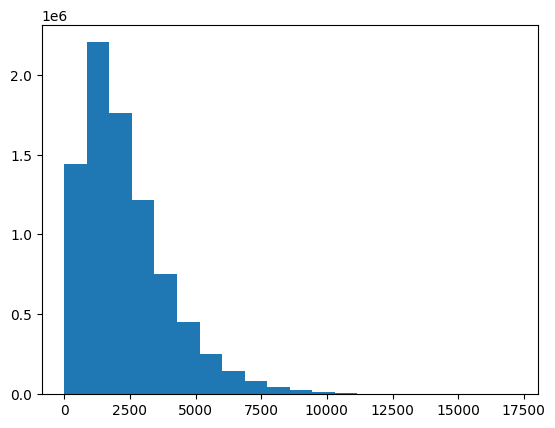

In [9]:
# draw scatter plot

plt.hist(journeys_gdf['distance'], bins = 20)


In [10]:
# calculate average speed
journeys_gdf['ave_speed'] = journeys_gdf['distance'] / journeys_gdf['Total duration (ms)'] * 1000

## Consider the bike types

The 2 types of bikes existing may make a difference.

In [36]:
# compare the distances
journeys_gdf.groupby(by = 'Bike model').distance.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_24868\924047236.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_gdf.groupby(by = 'Bike model').distance.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,2279.410865,1656.945009,0.0,1085.307181,1906.495847,3087.379142,17170.775763
PBSC_EBIKE,606397.0,3124.616509,2014.003074,0.0,1651.065859,2757.887126,4181.514950,16682.920172


In [38]:
# compare the height difference
journeys_gdf.groupby(by = 'Bike model').height_diff.describe()

C:\Users\Soki\AppData\Local\Temp\ipykernel_24868\699735221.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_gdf.groupby(by = 'Bike model').height_diff.describe()


,count,mean,std,min,25%,50%,75%,max
Bike model,,,,,,,,
CLASSIC,7808234.0,-0.231310,9.00606,-43.875999,-3.996001,0.0,3.60825,43.875999
PBSC_EBIKE,606397.0,-0.073767,11.01310,-43.214748,-6.377500,0.0,6.23700,43.779247


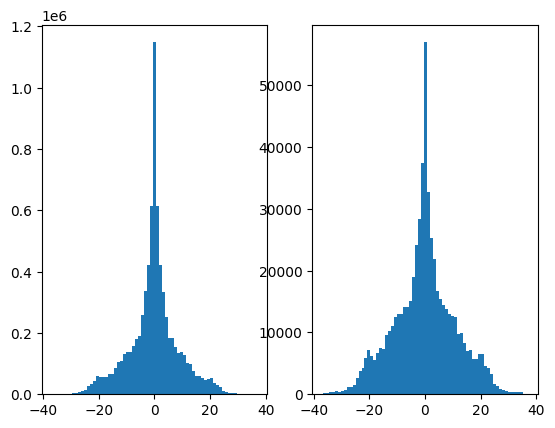

In [30]:
# set up plot
fig, axes = plt.subplots(1, 2)

# add histogram for classic cycles
axes[0].hist(
    journeys_gdf[journeys_gdf['Bike model'] == 'CLASSIC'].height_diff,
    bins = 81
)

# add histogram for ebikes
axes[1].hist(
    journeys_gdf[journeys_gdf['Bike model'] == 'PBSC_EBIKE'].height_diff,
    bins = 81
)


# set limits
for ax in axes:
    ax.set_xlim(-40.5, 40.5)

plt.show()

In [39]:
# conduct t-test


scipy.stats.ttest_ind(
    journeys_gdf[journeys_gdf['Bike model'] == 'CLASSIC'].height_diff,
    journeys_gdf[journeys_gdf['Bike model'] == 'PBSC_EBIKE'].height_diff
)

TtestResult(statistic=-12.893918258674379, pvalue=4.874543134223036e-38, df=8414629.0)